# Rays - Full season
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 45 # Rays
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrRays].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(10233, 55)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              10233 non-null  int64  
 1   dimCustomerMasterId       10233 non-null  int64  
 2   customerNumber            10231 non-null  object 
 3   year                      10233 non-null  int64  
 4   productGrouping           10233 non-null  object 
 5   totalSpent                10233 non-null  float64
 6   recentDate                10233 non-null  object 
 7   attendancePercent         10233 non-null  float64
 8   renewedBeforeDays         10233 non-null  int64  
 9   isBuyer                   10233 non-null  object 
 10  source_tenure             10233 non-null  int64  
 11  tenure                    10233 non-null  int64  
 12  distToVenue               10233 non-null  float64
 13  totalGames                10233 non-null  int64  
 14  recenc

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
                "dimCustomerMasterId",
                "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
df_dataset = df_dataset[df_dataset["productGrouping"] ==  'Full Season' ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2799, 19)
Unseen Data For Predictions: (494, 19)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8344,0.8752,0.9018,0.8385,0.8687,0.6451,0.6491,0.3070
lr,Logistic Regression,0.6906,0.7281,0.8887,0.6916,0.7775,0.2950,0.3207,0.4240


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8319,0.8848,0.9097,0.8291,0.8675,0.6390,0.6442
1,0.8487,0.9016,0.9097,0.8506,0.8792,0.6776,0.6803
2,0.8151,0.8653,0.8681,0.8333,0.8503,0.6088,0.6097
3,0.8025,0.8303,0.9034,0.7988,0.8479,0.5695,0.5783
4,0.8361,0.8631,0.9034,0.8397,0.8704,0.6484,0.6516
5,0.8319,0.8575,0.9241,0.8221,0.8701,0.6343,0.6431
6,0.8824,0.9094,0.9379,0.8774,0.9067,0.7481,0.7511
7,0.8403,0.9131,0.8759,0.8639,0.8699,0.6634,0.6635
8,0.8109,0.8560,0.8621,0.8333,0.8475,0.5990,0.5996
9,0.8439,0.8713,0.9236,0.8365,0.8779,0.6630,0.6693


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(264, 55)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,urbanicity,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,isNextYear_Buyer,Label,Score_0,Score_1
7642,45,28368597,1684946,2021,Full Season,2130.0,2021-09-21,0.60000,25,TRUE,...,0,0,0,0,0,0.0,1,0,0.9013,0.0987
7645,45,28375191,100634421,2021,Full Season,4260.0,2021-09-26,0.89375,27,TRUE,...,0,0,0,0,0,0.0,1,0,0.6603,0.3397
7647,45,28379032,4315740,2021,Full Season,15092.0,2021-09-26,1.00625,18,TRUE,...,0,0,0,0,0,0.0,1,0,0.9178,0.0822
7665,45,35056409,126231,2021,Full Season,1039.0,2021-09-26,1.02500,27,TRUE,...,0,0,0,0,0,0.0,1,0,0.9941,0.0059
7849,45,44370346,2784311,2021,Full Season,24164.0,2021-09-20,0.07619,11,TRUE,...,0,0,0,0,0,0.0,1,0,0.7949,0.2051


In [11]:
new_predictions["Label"].value_counts()

0    239
1     25
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    186
(0.2, 0.4]        45
(0.4, 0.6]        12
(0.6, 0.8]        12
(0.8, 1.0]         9
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

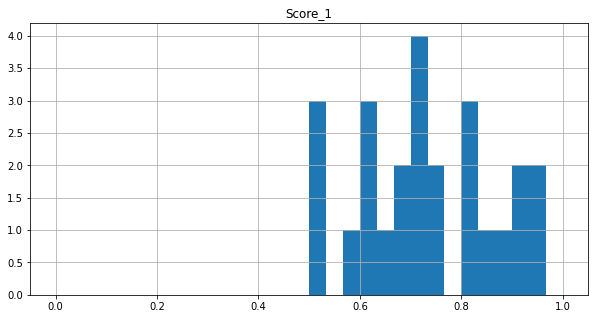

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

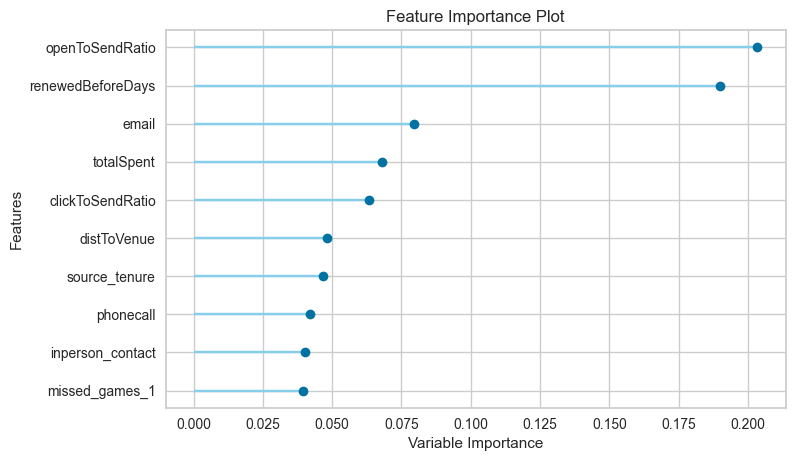

In [14]:
plot_model(best_model, plot='feature')

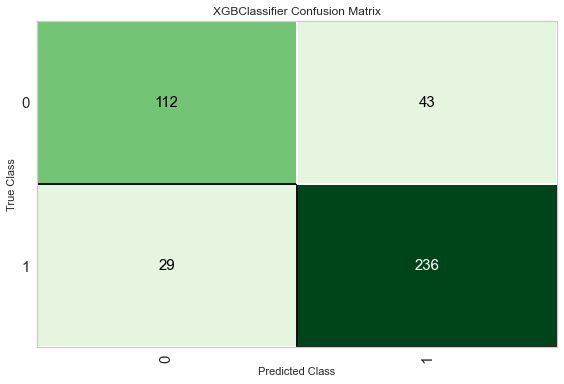

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?